In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install wordcloud
!pip install tweet-preprocessor

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
import tensorflow as tf
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

import preprocessor as p

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Download and Load data from Kaggle directly

In [4]:
# Install Kaggle API
!pip install --quiet kaggle

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
 # Choose kaggle.json that created for new API token in your account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"orchidchetiaphukan","key":"099afcb8eb32dde9885cd0bdf0e3389b"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Check the file in its new directory
!ls /root/.kaggle/
# Check the file permission
!ls -l ~/.kaggle/kaggle.json
#Change the file permission
# chmod 600 file – owner can read and write
# chmod 700 file – owner can read, write and execute
!chmod 600 ~/.kaggle/kaggle.json

input  kaggle.json
-rw------- 1 root root 74 Jul 12 04:40 /root/.kaggle/kaggle.json


In [8]:
! kaggle datasets download -d 'kazanova/sentiment140'
!unzip -q sentiment140.zip  -d .

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [9]:
! ls /content

 drive		    kaggle.json   sentiment140.zip
'kaggle (1).json'   sample_data   training.1600000.processed.noemoticon.csv


In [10]:
!mkdir /root/.kaggle/input

mkdir: cannot create directory ‘/root/.kaggle/input’: File exists


In [11]:
!cp training.1600000.processed.noemoticon.csv  ~/.kaggle/input

In [12]:
!ls /root/.kaggle/input

training.1600000.processed.noemoticon.csv


# Classification of Depressive and Normal Tweets

## Datasets

###For this analysis Sentiment140 Dataset is used 
https://www.kaggle.com/kazanova/sentiment140


In [13]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

dataset = pd.read_csv('/root/.kaggle/input/training.1600000.processed.noemoticon.csv', encoding=encoding, names=col_names)

In [14]:
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
df = dataset.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

,text,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps fo...",0
766711,@TiannaChaos i know just family drama. its la...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


In [16]:
df.shape

(8000, 2)

### Dataset scraped by twint
https://github.com/peijoy/DetectDepressionInTwitterPosts

In [17]:
col_names = ['id', 'text']
df2 = pd.read_csv('/content/drive/MyDrive/Depression_Detector/depressive_tweets_processed.csv', 
                  sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names) 
df2.head()

,id,text
0,989292962323615744,The lack of this understanding is a small but ...
1,989292959844663296,i just told my parents about my depression and...
2,989292951716155392,depression is something i don't speak about ev...
3,989292873664393218,Made myself a tortilla filled with pb&j. My de...
4,989292856119472128,@WorldofOutlaws I am gonna need depression med...


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2345 non-null   object
 1   text    2313 non-null   object
dtypes: object(2)
memory usage: 36.8+ KB


In [19]:
df2.shape

(2345, 2)

In [20]:
# add `label` colum with value 1's
df2['label'] = 1
df2 = df2[['text', 'label']]

In [21]:
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset

0 : Not Depressed

1 : Depressed

In [22]:
df['label'].value_counts()

0    8000
1    2345
Name: label, dtype: int64

## Text Preprocessing

In [23]:
# Expand Contraction
clist =  pd.read_json('/content/drive/MyDrive/Depression_Detector/eng_contractions.txt', typ='series')
clist = clist.to_dict()

In [24]:
c_re = re.compile('(%s)' % '|'.join(clist.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)


In [25]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [26]:
X = clean_tweets([tweet for tweet in df['text']])
X = [str(i) for i in X]
print(X[0:5])

['no82 thank', 'really sad still hurricane jackies least', 'darthvader wookiees oh woes blatant marketing', 'dresses ready start daughters wedding dress gon na start today tortured dentist', 'good time anxiety depression pic twitter com bjuajju4vx']


## Word Analysis

In [27]:
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False,background_color='white', colormap="GnBu_r").generate(depressive_words)

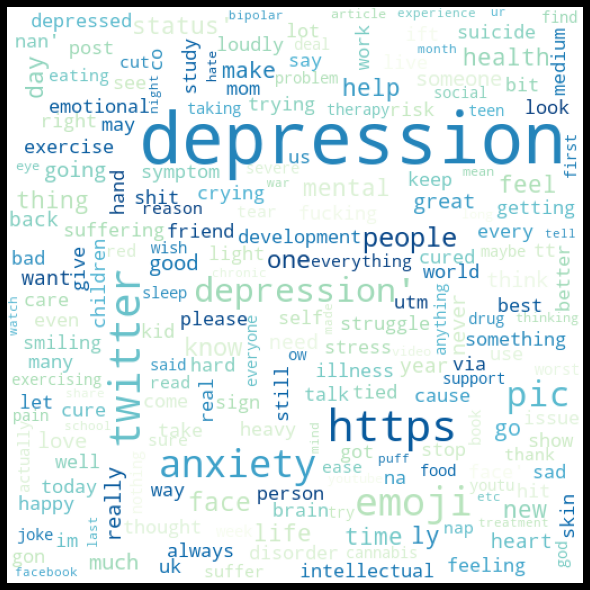

In [28]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Baseline Model

In [29]:
# X is the Feature after TEXT CLEANING IS DONE
y = df['label']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.1, random_state = 42)


In [31]:
# Train data Tokenization
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each Text.
MAX_SEQ_LENGTH = 140
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS,oov_token='OOV', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
word_vector = tokenizer.texts_to_sequences(X_train)
input_tensor = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH))
input_tensor.head()
print('Found %s unique tokens.' % len(word_index))

Found 19262 unique tokens.


In [32]:
# Saving the tokenizer as pickle file
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# Test data Tokenization
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH))
X_test.head()

In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True
callback = myCallback()

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Depression_Detector/main.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')
callbacks = [callback, checkpointer]

In [35]:
print(input_tensor.shape[1])

140


In [36]:
EMBEDDING_DIM = 300
def create_model():
   model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length = input_tensor.shape[1]),
                              tf.keras.layers.LSTM(300),
                              tf.keras.layers.Dense(100, activation="relu"),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')])

   return model

model = create_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [37]:
history = model.fit(input_tensor, y_train, batch_size=16, epochs=1 , callbacks = callbacks,validation_split = 0.1)

524/524 [==============================] - 309s 586ms/step - loss: 0.0852 - accuracy: 0.9727 - val_loss: 0.0305 - val_accuracy: 0.9936

Reached 97% accuracy so cancelling training!

Epoch 00001: val_accuracy improved from -inf to 0.99356, saving model to /content/drive/MyDrive/Depression_Detector/main.hdf5


In [38]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(y_pred)
print(type(y_pred))

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'>


In [39]:
from sklearn.metrics import classification_report
clreport = classification_report(y_test, y_pred)
print(clreport)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       834
           1       0.98      0.98      0.98       201

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035

